In [ ]:
#Install dependencies
!pip install stable-baselines3
!pip install 'shimmy>=2.0'
!pip install PyPortfolioOpt
!pip install gym==0.26.2
!pip install yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Imports Libs
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco

import gymnasium
from gymnasium import Env, spaces
import gym
from gym import spaces, Env
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise

from pypfopt import EfficientFrontier, risk_models, expected_returns


In [ ]:
#Download data
tickers = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS",
    "HINDUNILVR.NS", "SBIN.NS", "BAJFINANCE.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"
]
start_date = "2004-01-01"
end_date   = "2024-12-31"

# Download data (auto_adjust=True by default)
data = yf.download(tickers, start=start_date, end=end_date)["Close"].dropna()
data.to_csv("rl_port_data.csv")

# Daily returns
returns = data.pct_change().dropna()


[*********************100%***********************]  10 of 10 completed


In [ ]:
# Defining Gym environment
class PortfolioEnv(gym.Env):
    def __init__(self, price_df, window_size=126, hold_period=21):
        super().__init__()
        self.price_df    = price_df
        self.returns_df  = price_df.pct_change().dropna()
        self.window_size = window_size
        self.hold_period = hold_period
        self.num_assets  = self.returns_df.shape[1]

        # how many rebalances we can do
        self.max_steps   = (len(self.returns_df) - window_size) // hold_period

        # Observations: last window_size days of returns for all assets
        self.observation_space = spaces.Box(
            low   = -np.inf,
            high  =  np.inf,
            shape = (window_size, self.num_assets),
            dtype = np.float32
        )
        # Actions: weights for each asset
        self.action_space = spaces.Box(
            low   = 0.0,
            high  = 1.0,
            shape = (self.num_assets,),
            dtype = np.float32
        )
        self.reset()

    def reset(self):
        self.step_idx = 0
        self.start    = 0
        self.end      = self.window_size
        self.done     = False
        return self._get_obs()

    def _get_obs(self):
        return self.returns_df.iloc[self.start:self.end].values.astype(np.float32)

    def sortino_ratio(self, rets):
        downside = rets[rets < 0]
        if len(downside) == 0:
            return np.mean(rets) / 1e-6
        ds_std = np.std(downside)
        return np.mean(rets) / ds_std if ds_std > 0 else 0.0

    def step(self, action):
        # normalize weights
        w = np.array(action, dtype=np.float32)
        w = w / (w.sum() + 1e-8)

        # define next 21-day window
        start_ret = self.end
        end_ret   = start_ret + self.hold_period
        if end_ret > len(self.returns_df):
            self.done = True
            return self._get_obs(), 0.0, True, {}

        # agent portfolio returns
        R = self.returns_df.iloc[start_ret:end_ret].values
        port_rets = R @ w
        agent_sortino = self.sortino_ratio(port_rets)

        # equal-weight benchmark
        eq_w = np.ones(self.num_assets) / self.num_assets
        eq_sortino = self.sortino_ratio(R @ eq_w)

        # mean‑variance benchmark
        window_prices = self.price_df.iloc[self.start:self.end]
        mu = expected_returns.mean_historical_return(window_prices)
        S  = risk_models.sample_cov(window_prices)
        try:
            ef = EfficientFrontier(mu, S)
            mv_w = ef.max_sharpe()
            mv_vec = np.array([mv_w.get(t,0) for t in window_prices.columns])
            mv_w_norm = mv_vec / (mv_vec.sum() + 1e-8)
        except Exception:
            mv_w_norm = eq_w
        mv_sortino = self.sortino_ratio(R @ mv_w_norm)

        # reward = outperformance vs best benchmark
        reward = agent_sortino - max(eq_sortino, mv_sortino)

        # advance window
        self.step_idx += 1
        self.start = self.step_idx * self.hold_period
        self.end   = self.start + self.window_size
        obs = self._get_obs()
        return obs, reward, self.done, {}

    def seed(self, seed=None):
      self.np_random, seed = gym.utils.seeding.np_random(seed)
      return [seed]



In [ ]:
# Train PPO agent
env = make_vec_env(lambda: PortfolioEnv(data), n_envs=1)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("ppo_portfolio_model")


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 242      |
|    ep_rew_mean     | -41.6    |
| time/              |          |
|    fps             | 58       |
|    iterations      | 1        |
|    time_elapsed    | 34       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 242         |
|    ep_rew_mean          | -43.9       |
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 2           |
|    time_elapsed         | 71          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016455509 |
|    clip_fraction        | 0.0599      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0.00106     |
|    learnin

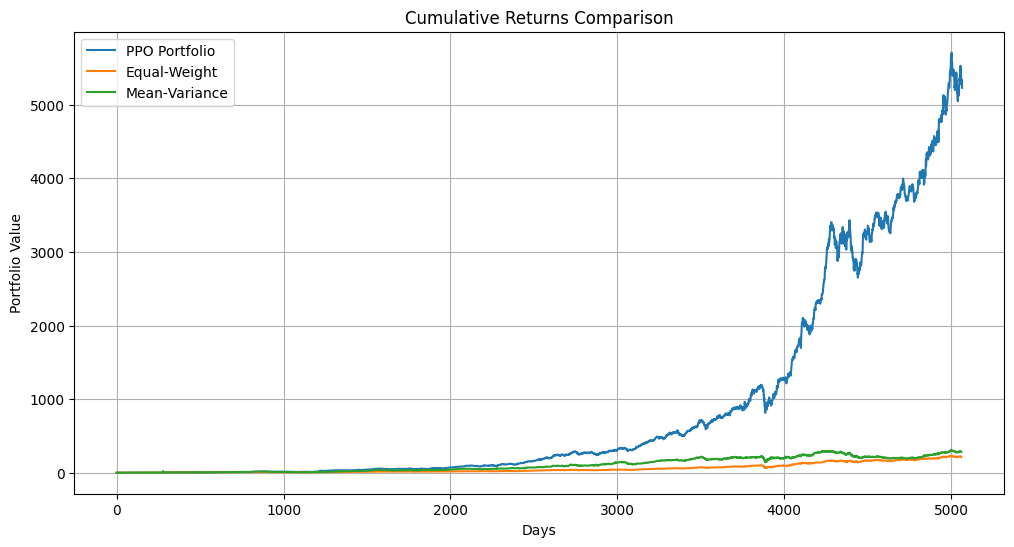

In [ ]:
# Evaluate & plot results
def evaluate_agent(model, price_df, returns_df, window_size=126, hold_period=21):
    env = PortfolioEnv(price_df, window_size, hold_period)
    obs = env.reset()
    vals = [1.0]
    while not env.done:
        action, _ = model.predict(obs, deterministic=True)
        w = action / (action.sum() + 1e-8)
        R = env.returns_df.iloc[env.end:env.end+hold_period].values
        for r in R @ w:
            vals.append(vals[-1] * (1 + r))
        obs, _, done, _ = env.step(action)
    return vals

def evaluate_baseline(strategy, price_df, returns_df, window_size=126, hold_period=21):
    env = PortfolioEnv(price_df, window_size, hold_period)
    vals = [1.0]
    while not env.done:
        if strategy == "equal":
            w = np.ones(env.num_assets) / env.num_assets
        else:
            window_prices = price_df.iloc[env.start:env.end]
            mu = expected_returns.mean_historical_return(window_prices)
            S  = risk_models.sample_cov(window_prices)
            try:
                ef = EfficientFrontier(mu, S)
                wdict = ef.max_sharpe()
                vec = np.array([wdict.get(t,0) for t in window_prices.columns])
                w = vec / (vec.sum() + 1e-8)
            except:
                w = np.ones(env.num_assets) / env.num_assets

        R = returns_df.iloc[env.end:env.end+hold_period].values
        for r in R @ w:
            vals.append(vals[-1] * (1 + r))
        # manually advance
        env.step_idx += 1
        env.start = env.step_idx * hold_period
        env.end   = env.start + window_size
        if env.end + hold_period > len(returns_df):
            break
    return vals

ppo_vals     = evaluate_agent(model, data, returns)
equal_vals   = evaluate_baseline("equal",   data, returns)
meanvar_vals = evaluate_baseline("meanvar", data, returns)

plt.figure(figsize=(12,6))
plt.plot(ppo_vals,     label="PPO Portfolio")
plt.plot(equal_vals,   label="Equal‑Weight")
plt.plot(meanvar_vals, label="Mean‑Variance")
plt.title("Cumulative Returns Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
